In [14]:
import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from scipy.sparse import csr_matrix

In [15]:
ran_state = 12

In [16]:
with open("train.dat", "r") as fh:
    lines = fh.readlines()  

In [17]:
len(lines)

8580

In [18]:
docs = [l.split() for l in lines]

In [19]:
len(docs)

8580

In [20]:
# #def csr_build(docs):
#     #build csr w/ our input data, format: index, value, index value.... etc
#     #should be even number of len for each line in doc(1 ind, 1 val)
#     #index is feature number, value is count of appearance in doc
#     #each line is a doc
# nrows = len(docs)
# nnz = 0
# biggest_feature_id = 0
# for d in docs:
    
#     #divide by two because not all are words/indices, half are values
#     nnz += len(d) / 2
#     #need to only look at values so skip 1 each time..
#     for w in range(0, len(d), 2):
#         if(biggest_feature_id < int(d[w])):
#             biggest_feature_id = int(d[w])
            
# ncols = biggest_feature_id
# #memory
# ind = np.zeros(nnz, dtype = np.int)
# val = np.zeros(nnz, dtype = np.double)
# ptr = np.zeros(nrows+1, dtype = np.int)
# n = 0
# i = 0

# for d in docs:
#     for w in range(0, len(d), 2):
#         ind[n] = int(d[w])
#         val[n] = int(d[w+1])
#         n += 1
#     ptr[i+1] = n
#     i += 1
    
# mat = csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.double)
    
# ####-----#### 
# #i did this first implementation same as ACT-data3 but i cannot use TruncatedSVD feature decomposition
# #on this csr_matrix because I have memory errors because the mapped ind values are extremely high
# #thus on the next implementation/example shown I map in dict to track original id to unique general id created by myself
# #which lowers the ind values by a TON for memory allocation in truncatedSVD
# #print(mat.shape[1])
# #print(mat.shape)
# #list(ind)       
# #len(ind)       
        
    

In [21]:
#####DICT######
#def csr_build(docs):
    #build csr w/ our input data, format: index, value, index value.... etc
    #should be even number of len for each line in doc(1 ind, 1 val)
    #index is feature number, value is count of appearance in doc
    #each line is a doc
nrows = len(docs)
nnz = 0
biggest_feature_id = 0
for d in docs:
    
    #divide by two because not all are words/indices, half are values
    nnz += len(d) / 2
    #need to only look at values so skip 1 each time..
    for w in range(0, len(d), 2):
        if(biggest_feature_id < int(d[w])):
            biggest_feature_id = int(d[w])
            
ncols = biggest_feature_id
#memory
ind = np.zeros(nnz, dtype = np.int)
val = np.zeros(nnz, dtype = np.double)
ptr = np.zeros(nrows+1, dtype = np.long)
ind_dict = dict()
n = 0
i = 0
index = 0
for d in docs:
    for w in range(0, len(d), 2):
        if not d[w] in ind_dict:
            ind_dict[d[w]] = index
            index+=1
        ind[n] = ind_dict[d[w]]
        val[n] = int(d[w+1])
        n += 1
    ptr[i+1] = n
    i += 1
    
mat = csr_matrix((val, ind, ptr), dtype=np.long)
# list(ind)
# len(ind)

In [22]:
mat.shape[1]

27673

In [23]:
mat.shape

(8580, 27673)

In [24]:
mat.shape[1]-1

27672

In [25]:
from sklearn.decomposition import TruncatedSVD

In [26]:
#find n_components where explained variance still > 90%, use #features-1 to test
#used n_iter=5(also default val) b/c it is higher for sparse matrices that may
#have slowly decaying spectrum
svd = TruncatedSVD(n_components=1500, n_iter=5, random_state=ran_state)
svd_test_fit = svd.fit(mat) 

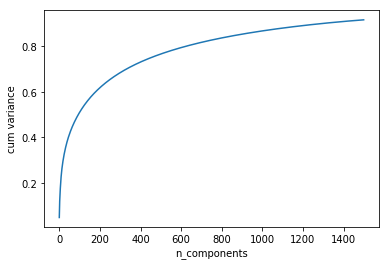

In [27]:
#explained variance graph
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('n_components')
plt.ylabel('cum variance')
plt.show()

In [28]:
#calculating n_compoenets required for explained variance of 90%
#usually standard is 95% but we want to reduce dimensions a lot so it's easier
#to create distance matrix..
variance_ratios = svd.explained_variance_ratio_
total_variance = 0.0;
req_variance = 0.90
n = 0
#set correct n to 0 so i can check after it is was even set(0 return means not
#found within the n_components provided, need to increase
correct_n = 0
for ratio in variance_ratios:
    total_variance += ratio
    n += 1
    if total_variance >= req_variance:
        correct_n = n
        break
print(correct_n)
#100 not enough, increase to 1000 for truncatedSVD call.
#1000 not enough either... increase to 1500
#1500 not enough either, increase to 2200
    

1292


In [29]:
#using found n_components perform svd on matrix for features = correct_n
#used n_iter=5(also default val) b/c it is higher for sparse matrices that may
#have slowly decaying spectrum
tsvd = TruncatedSVD(n_components=correct_n, n_iter=5, random_state=ran_state)
reduced_X = tsvd.fit_transform(mat)

In [30]:
reduced_X.shape

(8580L, 1292L)

In [31]:
checker = 0
for row in reduced_X:
    checker +=1
print(checker)
print checker, 

8580
8580


In [32]:
reduced_X[0, :]

array([ 5.22421399, -0.16990847, -2.4107291 , ..., -0.2263277 ,
        0.28811726,  0.24101835])

In [33]:
len(reduced_X)

8580

In [34]:
#not allowed to use distance matrix
#test_dist_matrix = sp.spatial.distance.pdist(reduced_X, metric='euclidean')

In [35]:
#not allowed to use distance matrix
#test_dist_matrix.shape
#shape = 36803910L, remove after

In [36]:
len(reduced_X[0, :])

1292

In [44]:
#reindent after all things implemented..
#what kind of input to take in? np matrix?
#def DBScan(matrix, eps, minpts):
#can use basic libraries (sqrt, min, max etc). Also, you’re allowed to use the
#scipy library to do mathematical operations like the dot products
#dot product (a dot b) = a1b1 +.. adbd.. = signal aibi

def distance(x, y):
    dist = np.sqrt(sp.dot(x,x) + sp.dot(y,y) - 2 * sp.dot(x,y))
    return dist

def within_eps(x, y, eps):
    return distance(x,y) <= eps


def core_points(mat, eps, minpts):
    #use non-core-mat after for checking these to see if border pts
    #if core then true else(border or noise check next fcn) false
    testing = 0
    core_point_index_list = np.zeros(len(mat), dtype=np.bool)
    for i in range(len(mat)):
        #reset for every outerloop so check inner loop for 0 -> minpts
        current_min_pts = 0
        #variable to check if core point was found, if not add to non core point list
        if_nocore = False
        for j in range(len(mat)):
            #print "i: ", i, "j: ", j
            
            if i==j:
                #print "skip this i=j", i
                continue
            
            if current_min_pts == minpts-1:
                if within_eps(mat[i], mat[j], eps):
                    current_min_pts += 1
                    core_point_index_list[i]=True
                    #print "core point", i
                    if_nocore = True
                    break
            
            elif current_min_pts < minpts:
                if within_eps(mat[i], mat[j], eps):
                    current_min_pts += 1
                    #print i, "within eps of ", j
            
            else:
                core_point_index_list[i]=True
                #print "core point", i
                if_nocore = True
                break
                
            
                
        if not if_nocore:
            core_point_index_list[i]=False
            #print "non core point", i
        
    return core_point_index_list


def border_points(mat, core_noncore_list):
    core_border_list = np.zeros(len(mat), dtype=np.bool)
    for j in range

In [45]:
len(reduced_X)
test_eps = 10
test_min = 3
reduced_X_core_list = core_points(reduced_X, test_eps, test_min)
print(len(reduced_X_core_list))


8580


In [46]:
print(reduced_X_core_list)

[False False False ... False False False]


In [47]:
#finds the number of true, aka core points in a list
sum(reduced_X_core_list)

1712

In [48]:
type(reduced_X_core_list)

numpy.ndarray

In [39]:
#testing core_points
test_matrix = [[2,4],[5,7],[9,10],[3,1]]
test_eps = 7
test_min = 3
test_matrix_core_point_list = core_points(test_matrix, test_eps, test_min)

print(len(test_matrix_core_point_list))
print(test_matrix_core_point_list)

4
[False, True, False, False]


In [40]:
#testing distance def...
t1 = np.array([2,4,6])
t2 = np.array([3,6,9])

t_dist = distance(t1,t2)
print(t_dist)

3.7416573867739413


In [41]:
#testing within_eps
t1 = np.array([2,4,6])
t2 = np.array([3,6,9])

t_eps_check = within_eps(t1,t2, 3.0)
print(t_eps_check)
#eucl dist is ~3.71 so > 3.0 not in eps

False


In [42]:
#testing within_eps
t1 = np.array([2,4,6])
t2 = np.array([3,6,9])

t_eps_check = within_eps(t1,t2, 4.0)
print(t_eps_check)
#eucl dist is ~3.71 so < 4.0 not in eps

True
